In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

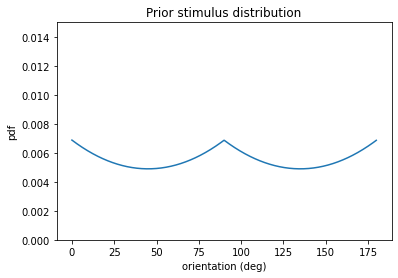

In [4]:
# "Natural prior" (Girshick et al. 2011, fig.6)
n_ori = 1000
a = 2e-4
b = 1

dori = 180 / n_ori
stim_dirs = np.float32(np.arange(0, 180, dori))
stim_p = np.zeros(n_ori)
midindx = np.argmin(np.abs(stim_dirs-90))

stim_p[:midindx] = a*(np.arange(0, stim_dirs[midindx], stim_dirs[midindx] / midindx)-45)**2 + b
stim_p[midindx:] = a*(np.arange(stim_dirs[midindx+1],
                               180, (180-stim_dirs[midindx+1]) / (n_ori-midindx)
                              )-135)**2 + b

plt.figure()
stim_p = stim_p/np.sum(stim_p)
plt.plot(stim_dirs,stim_p/dori)
plt.ylim([0,0.015])
plt.xlabel('orientation (deg)')
plt.ylabel('pdf')
plt.title('Prior stimulus distribution')

stim_cdf = np.cumsum(stim_p)



array([0.00123818, 0.00247351, 0.003706  , 0.00493567, 0.00616252,
       0.00738656, 0.00860781, 0.00982629, 0.01104199, 0.01225493,
       0.01346513, 0.01467259, 0.01587733, 0.01707936, 0.01827868,
       0.01947532, 0.02066927, 0.02186056, 0.0230492 , 0.02423519,
       0.02541854, 0.02659928, 0.02777741, 0.02895293, 0.03012588,
       0.03129624, 0.03246404, 0.03362929, 0.034792  , 0.03595218,
       0.03710984, 0.03826499, 0.03941765, 0.04056782, 0.04171552,
       0.04286076, 0.04400355, 0.0451439 , 0.04628183, 0.04741734,
       0.04855044, 0.04968115, 0.05080948, 0.05193544, 0.05305904,
       0.0541803 , 0.05529922, 0.05641581, 0.05753009, 0.05864208,
       0.05975177, 0.06085918, 0.06196432, 0.06306721, 0.06416786,
       0.06526627, 0.06636246, 0.06745644, 0.06854822, 0.06963782,
       0.07072524, 0.07181049, 0.0728936 , 0.07397456, 0.07505339,
       0.0761301 , 0.0772047 , 0.07827721, 0.07934764, 0.08041599,
       0.08148228, 0.08254652, 0.08360872, 0.0846689 , 0.08572

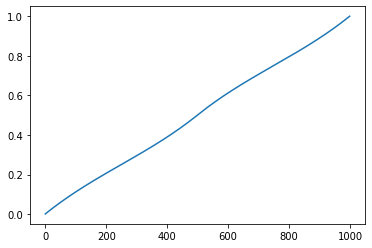

In [5]:
stim_cdf = np.cumsum(stim_p)
plt.figure()
plt.plot(stim_cdf)
stim_cdf

In [47]:
logits = tf.convert_to_tensor(np.linspace(-np.pi, np.pi,30),dtype=tf.float32)
laplac = np.zeros(logits.shape[0])
laplac[0] = -0.25
laplac[1] = 0.5
laplac[2] = -0.25
spectrum = tf.signal.fft(tf.cast(laplac, tf.complex64))
laplac = tf.linalg.LinearOperatorCirculant(spectrum,input_output_dtype=tf.float32)

# Recurrent gradient computations in TF 2
tldr: it works pretty well, even if the variables are overwritten!

In [35]:
x = tf.Variable([1.0, 2.0], dtype = tf.float32)
c = tf.constant([3.0, 3.0], dtype = tf.float32)

with tf.GradientTape() as tape0:
    y = x * c
    loss = tf.reduce_mean(y)
grads = tape0.gradient(loss,x)
grads

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5, 1.5], dtype=float32)>

In [36]:
x = tf.Variable([1.0, 2.0], dtype = tf.float32)
c = tf.constant([3.0, 3.0], dtype = tf.float32)

with tf.GradientTape() as tape1:
    x = x * c
    loss = tf.reduce_mean(x)
grads = tape1.gradient(loss,x)
grads # this calculates gradient with respect to the second x (after multiplying c)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5, 0.5], dtype=float32)>

In [54]:
s1  = tf.constant([5.0, 1.0], dtype = tf.float32)
s2  = tf.constant([1.0, 3.0], dtype = tf.float32)
w   = tf.Variable([3.0, 3.0], dtype = tf.float32)
h1  = tf.Variable([1.0, 2.0], dtype = tf.float32)
h2  = tf.Variable([1.0, 2.0], dtype = tf.float32)
c   = tf.constant([3.0, 3.0], dtype = tf.float32)

with tf.GradientTape() as tape2:
    h1 = s1 * w
    h2 = h1 + s2 * w
    loss = tf.reduce_mean(h2)
grads = tape2.gradient(loss,w)
print(grads) # calculates gradient with respect to the second x (after multiplying c)

tf.Tensor([3. 2.], shape=(2,), dtype=float32)


In the case in which the hidden variable $h$ is overwritten, the graph is updated so that the gradient is computed with respect to both the first h and the second h.

In [53]:
s1  = tf.constant([5.0, 1.0], dtype = tf.float32)
s2  = tf.constant([1.0, 3.0], dtype = tf.float32)
w   = tf.Variable([3.0, 3.0], dtype = tf.float32)
h  = tf.Variable([1.0, 2.0], dtype = tf.float32)
c   = tf.constant([3.0, 3.0], dtype = tf.float32)

with tf.GradientTape() as tape2:
    h = s1 * w
    h = h + s2 * w # overwrite variable h
    loss = tf.reduce_mean(h)
grads = tape2.gradient(loss,w)
print(grads) # calculates gradients from both h1 and h2

tf.Tensor([3. 2.], shape=(2,), dtype=float32)


In [59]:
sens_m = tf.random.poisson([3], 3, dtype=tf.float32, name = 'sensory_noise')
sens_m

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([4., 4., 1.], dtype=float32)>

# Hyperparameter search
Testing implementation of hyperparameter search using itertools.product

In [67]:
import itertools

In [79]:
for a in itertools.product('ABCD', [1,2]):
    print(a)

('A', 1)
('A', 2)
('B', 1)
('B', 2)
('C', 1)
('C', 2)
('D', 1)
('D', 2)


In [90]:
hplist = {'a': [1,2,3,4],
          'b': [1,2,3,4],
         'c' : ['uni', 'eff']}

for a in hplist:
    print(a)

names = []
lists = []
for (key, value) in hplist.items():
    names += [key]
    lists += [value]
print(lists)

b = itertools.product(*lists)
for a in itertools.product(*lists):
    print(a)

a
b
c
[[1, 2, 3, 4], [1, 2, 3, 4], ['uni', 'eff']]
(1, 1, 'uni')
(1, 1, 'eff')
(1, 2, 'uni')
(1, 2, 'eff')
(1, 3, 'uni')
(1, 3, 'eff')
(1, 4, 'uni')
(1, 4, 'eff')
(2, 1, 'uni')
(2, 1, 'eff')
(2, 2, 'uni')
(2, 2, 'eff')
(2, 3, 'uni')
(2, 3, 'eff')
(2, 4, 'uni')
(2, 4, 'eff')
(3, 1, 'uni')
(3, 1, 'eff')
(3, 2, 'uni')
(3, 2, 'eff')
(3, 3, 'uni')
(3, 3, 'eff')
(3, 4, 'uni')
(3, 4, 'eff')
(4, 1, 'uni')
(4, 1, 'eff')
(4, 2, 'uni')
(4, 2, 'eff')
(4, 3, 'uni')
(4, 3, 'eff')
(4, 4, 'uni')
(4, 4, 'eff')


# Circular statistics and derivatives
HG's error implementation vs mine?

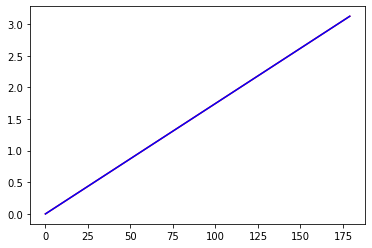

In [110]:
post_support    = np.arange(0, np.pi, np.pi / 180) # 0 to pi
post_sinr       = np.sin(2 * post_support)
post_cosr       = np.cos(2 * post_support)  # why multiply by 2 to average in 2pi..?

# take the (circular) posterior mean; then convert to 0 to pi.
post_mean = np.arctan2(post_sinr, post_cosr)/2 #-pi to pi

plt.figure()
plt.plot(np.mod(post_support,np.pi),'r')
plt.plot(np.mod(post_mean,np.pi),'b')

In [112]:
## todo: exercise:

# population tuning (1 distribution for vonMises likelihood in the sensory space) neural network to define sensory inputs and outputs
sens_mu = tf.math.acos(tf.math.cos(self.stim_tuning(neural_input))/(1+EPSILON)) # convert range to 0 to pi
# note derivaitve of acos(x) is nan if x = 1; so I scale by epsilon here...
# note: the derivative here is very weird. tuning = 0 deg has almost infinite gradient
# deriviatve of asin(sin(x)) = tan(X), and d of acos(cos(x)) = cot(x) [ infinite at different locations]
sens_mu = tf.math.asin(tf.math.sin(self.stim_tuning(neural_input))/(1+EPSILON)) # convert range to 0 to pi

sens_mu = tf.math.floormod(self.stim_tuning(neural_input),tf.constant(np.pi))
# note: if you use mod, the operation is not circular => so the derivative might go a wrong way
sens_mu_real = self.stim_tuning(neural_input)
sens_mu = tf.math.atan2(tf.math.sin(sens_mu_real), tf.math.cos(sens_mu_real))

<tf.Tensor: shape=(), dtype=float32, numpy=1.5707963>

# Gradient over poisson samples
Doesn't work.

In [97]:
x = tf.Variable(5,dtype = tf.float32)
with tf.GradientTape() as tape:
    samples = tf.random.poisson((1,), x)
tape.gradient(samples,x)

LookupError: gradient registry has no entry for: RandomPoissonV2

In [ ]:
to use tensorboard: 
    %tensorboard --logdir logs/fit

In [ ]:
# plot distribution of kappas